<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import multistock

from utils import *
from indicators import *
from dataset import Dataset
from forecaster import Forecaster
from solver import Solver
from os.path import join, isfile
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()
%matplotlib inline

/Users/achar/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/achar/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/achar/miniconda3/envs/py37/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the pu

[*********************100%***********************]  5 of 5 completed


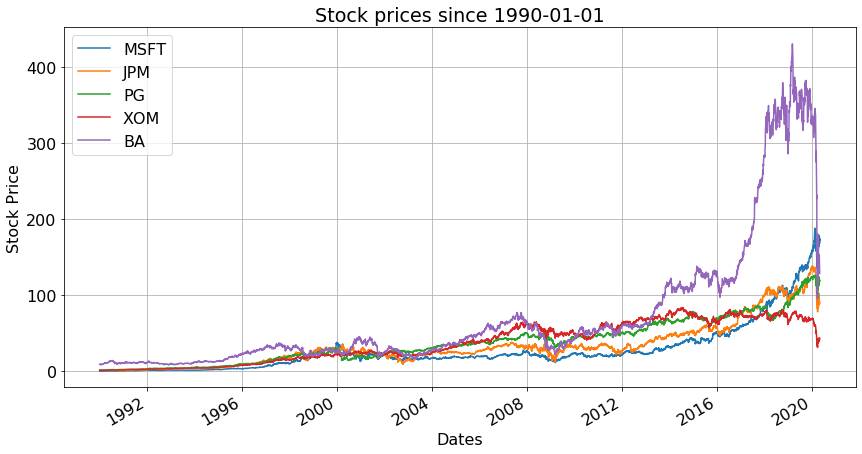

In [2]:
tickers = ['MSFT', 'JPM', 'PG', 'XOM', 'BA']
startdate = "1990-01-01"

df_prices = pdr.get_data_yahoo(tickers, start=startdate, groupby='ticker')

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(11, 5))
ax = fig.add_axes([0, 0, 1, 1])
for tick in tickers:
    df_prices['Adj Close'][tick].plot(y=tick, ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Stock Price')
ax.set_title('Stock prices since ' + startdate)
ax.legend()
fig.autofmt_xdate(rotation=30)
ax.grid()
plt.show()

In [24]:
batch_size = 14
seq_length = 10

# test_type = 'all_stocks'
test_type = 'all_stocks'

technical_indicators = [
    sma,  # Simple Moving Average
    wma,  # Weighted Moving Average
    mom,  # Exponential Moving Average
    macd,  # Moving Average Convergence Divergence
#     rsi,  # Relative Strength Indicator
    stoch,  # Stochastic %K and %D
    willr,  # Larry Williams %R
    adosc,  # Accumulation / Distribution Oscillator
]

# Load parameter file
with open('params/stocks.yaml') as file:
    params = yaml.full_load(file)

multi_features, mulit_labels = multistock.cleanData(df_prices,
                                                    technical_indicators,
                                                    params,
                                                    predict=7)

tick = next(iter(multi_features))
n_features = multi_features[tick].shape[1]

features = np.empty(shape=(0, n_features))
for tick in multi_features.keys():
    features = np.concatenate((features, multi_features[tick]))

scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler = scaler.fit(features)

result = multistock.train_test_split(multi_features, mulit_labels, scaler,
                                     seq_length, n_features=n_features, 
                                     test_type='new_stocks', test_size=0.25)

X_train, X_test, y_train, y_test = result

print('X Train Shape: ', X_train.shape)
print('X Test Shape: ', X_test.shape)
print('Y Train Shape: ', y_train.shape)
print('Y Test Shape: ', y_test.shape)

data_sets = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_test, y_test)
}
dataloaders = {
    x: DataLoader(data_sets[x], batch_size=batch_size, shuffle=True)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

baseline = np.ones_like(y_test)
accuracy = accuracy_score(y_test, baseline)
print(f'Average Baseline Accuracy: {accuracy * 100:.2f}%')

Creating features for BA
Removing 40 rows from data
Creating features for JPM
Removing 40 rows from data
Creating features for MSFT
Removing 40 rows from data
Creating features for PG
Removing 40 rows from data
Creating features for XOM
Removing 40 rows from data
Using XOM data for testing
X Train Shape:  (30356, 10, 9)
X Test Shape:  (7589, 10, 9)
Y Train Shape:  (30356, 1)
Y Test Shape:  (7589, 1)
Average Baseline Accuracy: 57.23%


In [25]:
model = Forecaster(n_features=n_features, n_hidden=32, n_layers=2, 
                   dropout=0.7)

solver = Solver(model, num_epochs=20, verbose=True, plot=True)
model = solver.train(dataloaders, dataset_sizes)

Using cpu for training.


Epoch: 1-train Loss: 0.6859 Acc: 0.5613
Epoch: 1-val Loss: 0.6829 Acc: 0.5723
Epoch: 2-train Loss: 0.6857 Acc: 0.5613
Epoch: 2-val Loss: 0.6843 Acc: 0.5723
Epoch: 3-train Loss: 0.6857 Acc: 0.5613
Epoch: 3-val Loss: 0.6829 Acc: 0.5723
Epoch: 4-train Loss: 0.6856 Acc: 0.5613
Epoch: 4-val Loss: 0.6833 Acc: 0.5723
Epoch: 5-train Loss: 0.6854 Acc: 0.5613
Epoch: 5-val Loss: 0.6823 Acc: 0.5723
Epoch: 6-train Loss: 0.6793 Acc: 0.5693
Epoch: 6-val Loss: 0.6615 Acc: 0.5826
Epoch: 7-train Loss: 0.6490 Acc: 0.6187
Epoch: 7-val Loss: 0.6619 Acc: 0.6046
Epoch: 8-train Loss: 0.6077 Acc: 0.6553
Epoch: 8-val Loss: 0.5816 Acc: 0.6884
Epoch: 9-train Loss: 0.5584 Acc: 0.7037
Epoch: 9-val Loss: 0.5153 Acc: 0.7446
Epoch: 10-train Loss: 0.5385 Acc: 0.7239
Epoch: 10-val Loss: 0.5052 Acc: 0.7546
Epoch: 11-train Loss: 0.5226 Acc: 0.7333
Epoch: 11-val Loss: 0.5201 Acc: 0.7270
Epoch: 12-train Loss: 0.5151 Acc: 0.7368
Epoch: 12-val Loss: 0.5033 Acc: 0.7392
Epoch: 13-train Loss: 0.5060 Acc: 0.7466
Epoch: 13-val Los

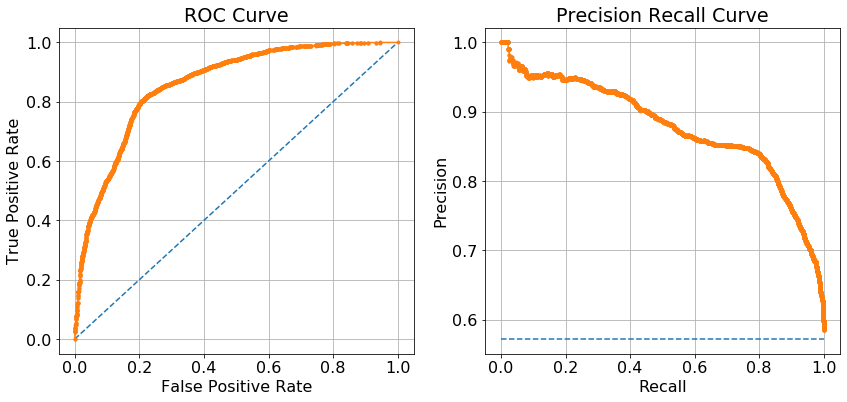

No Skill: ROC AUC=0.500
No Skill: Precision=0.572
No Skill: Recall=1.000
No Skill: Accuracy=0.572
-------------------------
LSTM Model: ROC AUC=0.860
LSTM Model: PR AUC=0.878
LSTM Model: Precision=0.794
LSTM Model: Recall=0.861
LSTM Model: Accuracy=0.793


In [15]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# Model and no skill guess (always trending up)
y_test, y_pred = solver.eval(model, dataloaders['val'])
ns_pred = np.ones_like(y_pred)

fig = plt.figure(figsize=(14, 6))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_pred)
ml_fpr, ml_tpr, _ = roc_curve(y_test, y_pred)

plt.subplot(1, 2, 1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(ml_fpr, ml_tpr, marker='.', label='LSTM Model')
plt.grid()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ml_precision, ml_recall, _ = precision_recall_curve(y_test, y_pred)
no_skill = len(y_test[y_test == 1]) / len(y_test)

plt.subplot(1, 2, 2)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(ml_recall, ml_precision, marker='.', label='LSTM Model')
plt.grid()
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Calculate scores
ns_roc_auc = roc_auc_score(y_test, ns_pred)
ml_roc_auc = roc_auc_score(y_test, y_pred)
ml_pr_auc = auc(ml_recall, ml_precision)

ml_classifications = classify(y_pred, threshold=0.5)
ns_classifications = classify(ns_pred, threshold=0.5)

ns_accuracy = accuracy_score(y_test, ns_classifications)
ns_precision = precision_score(y_test, ns_classifications)
ns_recall = recall_score(y_test, ns_classifications)

ml_accuracy = accuracy_score(y_test, ml_classifications)
ml_precision = precision_score(y_test, ml_classifications)
ml_recall = recall_score(y_test, ml_classifications)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_roc_auc))
print('No Skill: Precision=%.3f' % ns_precision)
print('No Skill: Recall=%.3f' % ns_recall)
print('No Skill: Accuracy=%.3f' % ns_accuracy)
print('-------------------------')
print('LSTM Model: ROC AUC=%.3f' % (ml_roc_auc))
print('LSTM Model: PR AUC=%.3f' % (ml_pr_auc))
print('LSTM Model: Precision=%.3f' % ml_precision)
print('LSTM Model: Recall=%.3f' % ml_recall)
print('LSTM Model: Accuracy=%.3f' % ml_accuracy)

In [10]:
modelparams = {}
modelparams['n_features'] = features.shape[1]
modelparams['n_hidden'] = 32
modelparams['n_layers'] = 2
modelparams['dropout'] = 0.7

solverparams = {}
solverparams['num_epochs'] = 10
solverparams['verbose'] = True
solverparams['plot'] = False

results = calcMetrics(modelparams, solverparams, dataloaders,
                      dataset_sizes, iters=5, threshold=0.5)
accuracy, precision, recall = results

print('LSTM Model: Accuracy=%.3f' % accuracy)
print('LSTM Model: Precision=%.3f' % precision)
print('LSTM Model: Recall=%.3f' % recall)

Model Evaluation #1
Using cpu for training.
Epoch: 1-train Loss: 0.3847 Acc: 0.8111
Epoch: 1-val Loss: 0.2791 Acc: 0.8755
Epoch: 2-train Loss: 0.2824 Acc: 0.8752
Epoch: 2-val Loss: 0.2814 Acc: 0.8740
Epoch: 3-train Loss: 0.2740 Acc: 0.8782
Epoch: 3-val Loss: 0.2677 Acc: 0.8804
Epoch: 4-train Loss: 0.2590 Acc: 0.8860
Epoch: 4-val Loss: 0.2475 Acc: 0.8925
Epoch: 5-train Loss: 0.2455 Acc: 0.8917
Epoch: 5-val Loss: 0.2112 Acc: 0.9087
Epoch: 6-train Loss: 0.2211 Acc: 0.9044
Epoch: 6-val Loss: 0.1863 Acc: 0.9183
Epoch: 7-train Loss: 0.1983 Acc: 0.9127
Epoch: 7-val Loss: 0.1804 Acc: 0.9250
Epoch: 8-train Loss: 0.1907 Acc: 0.9162
Epoch: 8-val Loss: 0.1662 Acc: 0.9277
Epoch: 9-train Loss: 0.1843 Acc: 0.9209
Epoch: 9-val Loss: 0.1584 Acc: 0.9331
Epoch: 10-train Loss: 0.1779 Acc: 0.9239
Epoch: 10-val Loss: 0.1680 Acc: 0.9283
Training complete in 3m 15s
Best val acc: 0.933061
Model Evaluation #2
Using cpu for training.
Epoch: 1-train Loss: 0.3863 Acc: 0.8107
Epoch: 1-val Loss: 0.4039 Acc: 0.8038
E